# Anomaly detection in fiber optic polarization
In this example we demonstrate the capabilities of Learning Entropy on anomaly detection of real data measured by CzechLight Polarilog [1]

[1] R. Vohnout, M. Šlapák, J. Jedlinský, and J. Vojtěch, “CzechLight Polarilog - Rapid Polarization Rotation Monitoring Appliance,” in 2020 22nd International Conference on Transparent Optical Networks (ICTON), Jul. 2020, pp. 1–4. doi: 10.1109/ICTON51198.2020.9203142.


In [55]:
# Import required libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import time
from pathlib import Path
from scipy.signal import spectrogram
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
import math

# Get access to root folder of the notebook
sys.path.append("..")

# Pythonic AISLE
from src.aisle import aisle as py_aisle
from src.aisle import aisle_window as py_aisle_window

# JAX accelerated AISLE
from src.aisle_jax import aisle as jax_aisle
from src.aisle_jax import aisle_window as jax_aisle_window

%matplotlib widget

In [62]:
# Define required functions
def visualize_input_data_spectrogram_and_train(path: str|Path)->None:
    """Visualize input data as spectrogram with shown train time."""
    # Load the data
    data = pd.read_pickle(path)

    # Convert the data to numpy array
    signal = data.values

    # Sampling frequency
    fs = 150  # Hz

    # Compute the spectrogram
    f, t, Sxx = spectrogram(signal, fs)

    # Convert to dB
    Sxx_db = 10 * np.log10(Sxx)

    # Plot the spectrogram
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, Sxx_db, shading='gouraud')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.title('Spectrogram of the Input Data')
    plt.show()

# Combine the signals using PCA
def combine_signals_with_pca(signal1, signal2, signal3):
    """
    Combine three polarization channels into one signal using PCA.

    :param signal1: First polarization channel (numpy array or pandas Series)
    :param signal2: Second polarization channel (numpy array or pandas Series)
    :param signal3: Third polarization channel (numpy array or pandas Series)
    :return: Combined signal (numpy array)
    """
    # Stack signals into a single matrix
    signals = np.vstack([signal1, signal2, signal3]).T

    # Standardize the signals
    scaler = StandardScaler()
    signals_standardized = scaler.fit_transform(signals)

    # Apply PCA
    pca = PCA(n_components=1)
    principal_component = pca.fit_transform(signals_standardized)

    # Rescale the principal component back to the original scale
    combined_signal = scaler.inverse_transform(pca.inverse_transform(principal_component)).flatten()

    return combined_signal

def visualize_input_data_spectrogram(signal)->None:
    """Visualize input data as spectrogram with shown train time."""


    # Sampling frequency
    fs = 150  # Hz

    # Generate the spectrogram
    frequencies, times, Sxx = spectrogram(signal, fs=fs, nperseg=256)

    # Plot the spectrogram
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
    plt.title('Spectrogram of PCA Transformed Data')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.colorbar(label='Intensity [dB]')
    plt.show()

In [68]:
signal_1 = pd.read_pickle(r"./example_4_data_ch1.pkl")
signal_2 = pd.read_pickle(r"./example_4_data_ch2.pkl")
signal_3 = pd.read_pickle(r"./example_4_data_ch3.pkl")
combined_signal = combine_signals_with_pca(signal_1, signal_2, signal_3)
combined_signal_df = pd.DataFrame(combined_signal, index=signal_1.index, columns=['combined_signal'])
combined_signal_df.to_csv(r"./combined_path.pkl")


ValueError: Shape of passed values is (486003, 1), indices imply (162001, 1)

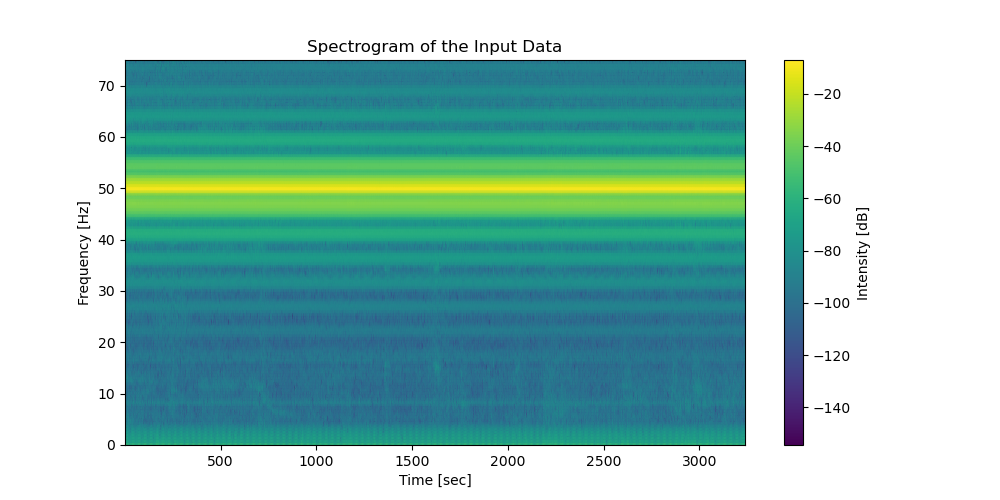

In [64]:
visualize_input_data_spectrogram(combined_signal)

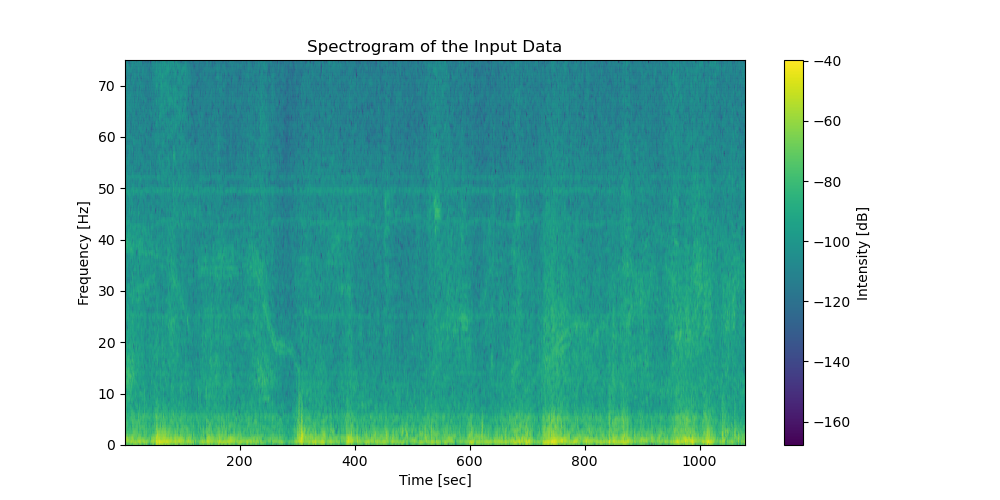

In [65]:
# Visualize input data
data_path = r"./example_4_data_ch3.pkl"
visualize_input_data_spectrogram_and_train(data_path)

In [66]:
# Prepare data scaler and scale data for training
# Load the data
data = pd.read_pickle(data_path)
fs = 150  # Hz
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data.values.reshape(-1, 1)).flatten()

In [67]:
data

datetime
2023-04-04 10:39:59.995253333    0.014960
2023-04-04 10:40:00.001920000    0.014912
2023-04-04 10:40:00.008586667    0.015039
2023-04-04 10:40:00.015253334    0.015217
2023-04-04 10:40:00.021920001    0.014896
                                   ...   
2023-04-04 10:57:59.968640665    0.019812
2023-04-04 10:57:59.975307332    0.019843
2023-04-04 10:57:59.981973999    0.019489
2023-04-04 10:57:59.988640666    0.019561
2023-04-04 10:57:59.995307333    0.019685
Freq: 6666667ns, Name: ch3, Length: 162001, dtype: float64

In [47]:
# Input data setup. The parameter and ny specify how many historic values from an input vector are be used
ny = 15
prediction_horizon = 10
N = data_normalized.shape[0]

X = np.ones((N, 1 + ny))  # On the first position we will keep bias
y = np.zeros((N,))

# Generate X, y dynamically based on 'ny'
for k in range(ny, N - prediction_horizon):
    X[k, 1:] = data_normalized[k - ny : k][::1]
    y[k] = data_normalized[k + prediction_horizon - 1]

X = X[ny:-prediction_horizon, :]
y = y[ny:-prediction_horizon]

In [48]:
# Train Neural Unit
mu = 0.001  # Learning rate
epochs = 5

# Initialize parameters
N = X.shape[0]
print(f"The total amount of samples: {N}.")
nw = X.shape[1]  # Get weights for neuron
r = 1  # Set the order of polynom
if r > 1:
    nw = math.ceil(math.factorial(nw + r - 1) / math.factorial(r) / math.factorial(nw - 1))
w = np.random.randn(nw) / nw
print(f"Total amount of trainable weights {nw}.")

# Holders for adaptation values
e = np.zeros(N)
yn = np.zeros(N)
wall = np.zeros((N, nw))

# Training Quadratic Neural Unit
for epoch in range(epochs):
    for k in range(N):
        # Prepare polynomial input vector
        if r > 1:
            outer_product = np.outer(X[k], X[k])
            upper_triangle = np.triu_indices_from(outer_product)
            x = outer_product[upper_triangle]
        else:
            x = X[k, :]

        yn[k] = np.dot(w, x)
        e[k] = y[k] - yn[k]

        dyndw = x  # Gradient

        # Update weights
        # Uncomment the desired weight update rule

        # Pure Gradient Descent (GD)
        # dw = mu * e[k] * dyndw

        # GD with normalization
        dw = mu / (sum(x * x)) * e[k] * dyndw  # x0=1 => division by zero is avoided

        # GD with normalization and momentum
        # dw = 0.2 * mu / (sum(x * x)) * e[k] * dyndw + 0.8 * dw

        w = w + dw  # Update weights
        wall[k, :] = w  # Store weights for analysis

    epoch_error = np.mean(e**2)
    print(f"Epoch {epoch+1} Mean Squared Error: {epoch_error}")

The total amount of samples: 161976.
Total amount of trainable weights 16.
Epoch 1 Mean Squared Error: 0.001006374580652474
Epoch 2 Mean Squared Error: 0.0008356740288615477
Epoch 3 Mean Squared Error: 0.0007951012935495924
Epoch 4 Mean Squared Error: 0.0007653534804765156
Epoch 5 Mean Squared Error: 0.0007395056898671917


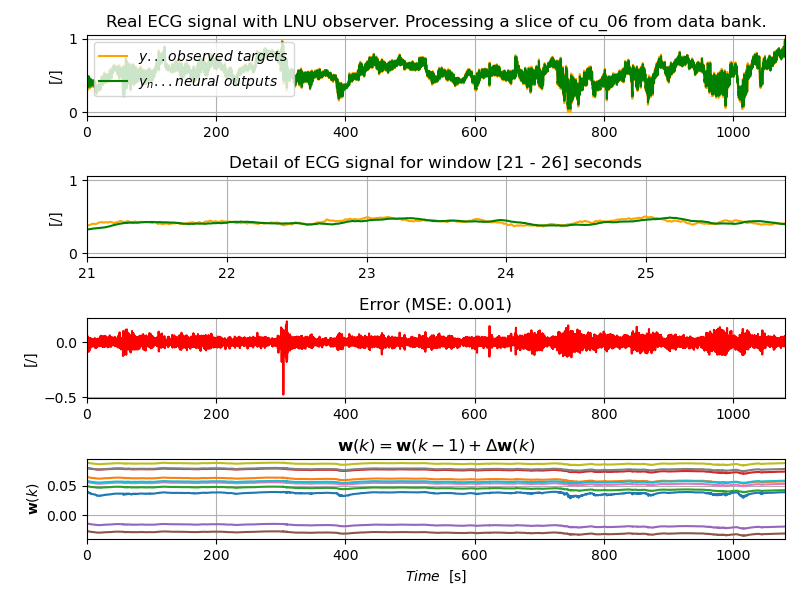

In [49]:
# Visualize model prediction
error = round(epoch_error, 3)
time_domain = np.arange(0, data.shape[0]) / fs
slice_start = 21
slice_end = 26


plt.figure(figsize=(8, 6))
# Plot observed target and neural output
ax1 = plt.subplot(411)
plt.title("Real ECG signal with LNU observer. Processing a slice of cu_06 from data bank.")
plt.plot(time_domain[ny:-prediction_horizon], y, "orange", label=r"$y ... observed \ targets$")
plt.plot(time_domain[ny:-prediction_horizon], yn, "g", label=r"$y_n ... neural \ outputs$")
plt.ylabel("[/]")
plt.legend(loc="upper left")
plt.xlim(time_domain[0], time_domain[-1])
plt.grid()

# Plot detain of ECG signal
ax2 = plt.subplot(412)
plt.title(f"Detail of ECG signal for window [{slice_start} - {slice_end}] seconds")
sample_range = np.arange(slice_start * fs, slice_end * fs) / fs
plt.plot(time_domain[ny:-prediction_horizon], y, "orange", label=r"$y ... observed \ targets$")
plt.plot(time_domain[ny + prediction_horizon :], yn, "g", label=r"$y_n ... neural \ outputs$")
plt.ylabel("[/]")
plt.xlim(sample_range[0], sample_range[-1])
plt.grid()

# Plot error between observed targets and neural outputs
ax3 = plt.subplot(413, sharex=ax1)
plt.plot(time_domain[ny + prediction_horizon :], e, "r", label=r"$e=y-y_n$")
plt.title(f"Error (MSE: {error})")
plt.ylabel("[/]")
plt.grid()

# Plot weights adaptation
ax4 = plt.subplot(414, sharex=ax1)
plt.plot(time_domain[ny + prediction_horizon :], wall[:, :10]), plt.ylabel(r"$\mathbf{w}(k)$")
plt.title(r"$\mathbf{w}(k)=\mathbf{w}(k-1)+\Delta \mathbf{w}(k)$")
plt.grid()
plt.xlabel(r"$Time$  [s]")

plt.tight_layout()
plt.show()

In [8]:
time_domain.shape

(162001,)

In [51]:
# Single AISLE value retrieval
oles = (1, 2)
alphas = (10, 15)

# Python single Learning Entropy evaluation
py_aisle_time = time.time()
py_aisle_value = py_aisle(wall, alphas=alphas, oles=oles)
py_aisle_time = time.time() - py_aisle_time

# JAX accelerated single Learning Entropy evaluation
jax_aisle_time = time.time()
jax_aisle_value = jax_aisle(wall, alphas=alphas, oles=oles)
jax_aisle_time = time.time() - jax_aisle_time

msg = (
    f"Single Learning Entropy evaluation with pythonic approach took: {py_aisle_time:.6f} seconds.\n",
    f"Single Learning Entropy evaluation with JAX aproach took: {jax_aisle_time:.6f} seconds.\n\n",
    "Single init evaluation with JAX is in general slower, as on its first run it has to compile parts of",
    " the code.\nRepeated usage is recommended.\n",
    "If reporting evaluation time is 0.000.., cache has been used and invalid time results are shown",
)
msg = "".join(text for text in msg)
print(msg)

Single Learning Entropy evaluation with pythonic approach took: 0.046016 seconds.
Single Learning Entropy evaluation with JAX aproach took: 0.031914 seconds.

Single init evaluation with JAX is in general slower, as on its first run it has to compile parts of the code.
Repeated usage is recommended.
If reporting evaluation time is 0.000.., cache has been used and invalid time results are shown


In [52]:
# AISLE setup
oles = (0, 1, 2)  # Order of LE
alphas = (5, 6, 7, 8)  # Sensitivity of evaluation
window = 15*150  # Window evaluated for each AISLE
threshold = 0.5  # Visual threshold (red dashed line)

# Sum, normalize and shift AISLE to correspond to original data
aisle_values = np.zeros(data.shape[0])
py_aisle_time = time.time()
py_aisle_values = py_aisle_window(window, wall, alphas, oles)
py_aisle_time = time.time() - py_aisle_time
aisle_values[ny:-prediction_horizon] = np.sum(py_aisle_values, axis=1) / len(oles)


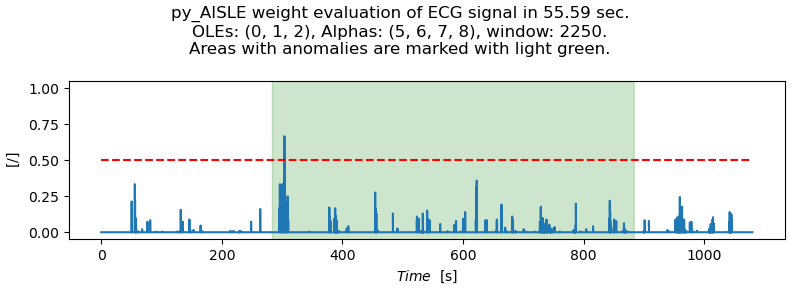

In [53]:
# Sort all indices in descending order
all_sorted_indices = np.argsort(aisle_values)[::-1]  # Sort all indices in descending order

# Define the range within which indices are considered too close
proximity_range = 2

# Filter indices that are too close, preferring the one with the higher value
# filtered_indices = []
# for index in all_sorted_indices:
#     if not any(abs(index - other_index) <= proximity_range for other_index in filtered_indices):
#         filtered_indices.append(index)

# Now select the top N indices after filtering
# N = 5  # Number of top indices to select
# final_indices = filtered_indices[:N]

# Construct the plot title with the top three significant values
# top_values_str = "times:" + ", ".join([f" {idx/fs}" for idx in final_indices])
plot_title = (
    f"py_AISLE weight evaluation of ECG signal in {py_aisle_time:.2f} sec.\n",
    f"OLEs: {oles}, Alphas: {alphas}, window: {window}.\n",
    # f"Top 5 significant detections at {top_values_str} sec.\n",
    "Areas with anomalies are marked with light green.",
)
plot_title = "".join(text for text in plot_title)

start = 21450 + 140*150
train_dt = start + 600*150
roi_ranges = (time_domain[start], time_domain[train_dt])

# Plotting
fig = plt.figure(figsize=(8, 3))
fig.suptitle(plot_title)
plt.plot(time_domain, aisle_values, label="AISLE")
plt.hlines([0.5], 0, aisle_values.shape[0] // fs, colors="red", linestyles="dashed")
plt.ylabel(r"$[/]$")
plt.xlabel(r"$Time$  [s]")

# Fill specified ROI ranges with green background
plt.fill_between(
    x=np.arange(roi_ranges[0] + ny / fs, roi_ranges[1] + 1), y1=-0.05, y2=1.05, color="green", alpha=0.2
)

# Places crosses on top indices
# for index in final_indices:
#     if index < len(aisle_values):  # Check to avoid indexing errors
#         plt.scatter(index / fs, aisle_values[index], color="red", marker="x", s=50)

plt.ylim((-0.05, 1.05))
plt.tight_layout()
plt.show()

In [34]:
train_dt = 21450 + 600*150
train_dt


111450

In [35]:
# AISLE setup
oles = (1,2,3)  # Order of LE
alphas = (4, 6, 7, 8, 9, 10)  # Sensitivity of evaluation
window = 300  # Window evaluated for each AISLE
threshold = 0.5  # Visual threshold (red dashed line)

# Sum, normalize and shift AISLE to correspond to original data
aisle_values = np.zeros(data.shape[0])
jax_aisle_time = time.time()
jax_aisle_values = jax_aisle_window(window, wall, alphas, oles)
jax_aisle_time = time.time() - jax_aisle_time
aisle_values[ny + prediction_horizon :] = np.sum(jax_aisle_values, axis=1) / len(oles)


# Sort all indices in descending order
all_sorted_indices = np.argsort(aisle_values)[::-1]  # Sort all indices in descending order

# Define the range within which indices are considered too close
proximity_range = 2

# # Filter indices that are too close, preferring the one with the higher value
# filtered_indices = []
# for index in all_sorted_indices:
#     if not any(abs(index - other_index) <= proximity_range for other_index in filtered_indices):
#         filtered_indices.append(index)

# Now select the top N indices after filtering
# N = 5  # Number of top indices to select
# final_indices = filtered_indices[:N]

# Construct the plot title with the top three significant values
# top_values_str = "times:" + ", ".join([f" {idx/fs}" for idx in final_indices])
plot_title = (
    f"jax_AISLE weight evaluation of ECG signal in {jax_aisle_time:.2f} sec.\n",
    f"OLEs: {oles}, Alphas: {alphas}, window: {window}.\n",
    # f"Top 5 significant detections at {top_values_str} sec.\n",
    "Areas with anomalies are marked with light green.",
)
plot_title = "".join(text for text in plot_title)

roi_ranges = (34, time_domain[-1])

# Plotting
fig = plt.figure(figsize=(8, 3))
fig.suptitle(plot_title)
plt.plot(time_domain, aisle_values, label="AISLE")
plt.hlines([0.5], 0, aisle_values.shape[0] / fs, colors="red", linestyles="dashed")
plt.ylabel(r"$[/]$")
plt.xlabel(r"$Time$  [s]")

# Fill specified ROI ranges with green background
plt.fill_between(
    x=np.arange(roi_ranges[0] + ny / fs, roi_ranges[1] + 1), y1=-0.05, y2=1.05, color="green", alpha=0.2
)

# # Places crosses on top indices
# for index in final_indices:
#     if index < len(aisle_values):  # Check to avoid indexing errors
#         plt.scatter(index / fs, aisle_values[index], color="red", marker="x", s=50)

plt.ylim((-0.05, 1.05))
plt.tight_layout()
plt.show()